In [1]:
!pip install numpy matplotlib scipy scikit-learn pandas seaborn --quiet

In [2]:
import logging
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field

# Set up logging
logging.basicConfig(
    filename='simulation.log',
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
# logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set up Seaborn for better visuals
sns.set_theme(style="whitegrid")

CO 
2
​	
 +4H 
2
​	
 →CH 
4
​	
 +2H 
2
​	
 O

In [5]:
@dataclass
class ReactorSettings:
    molar_mass_CO2: float = 44.01
    molar_mass_H2: float = 2.016
    molar_mass_CH4: float = 16.04
    molar_mass_H2O: float = 18.015
    molar_mass_O2: float = 32
    energy_per_mole_CH4: float = 165  # kJ per mole CH4
    energy_per_mole_H2O: float = 285.8  # kJ per mole H2O

@dataclass
class StorageTank:
    name: str
    capacity: float
    level: float = 0
    is_low: bool = False
    
    def add(self, amount):
        if self.level + amount > self.capacity:
            logger.warning(f"{self.name} tank is full. Cannot add more.")
            self.level = self.capacity
        self.level = min(self.capacity, self.level + amount)
    
    def remove(self, amount):
        if amount > self.level:
            logger.warning(f"Attempting to remove more than available in the {self.name} tank")
            amount = self.level  # Only remove what is available
        removed = min(self.level, amount)
        self.level -= removed
        if self.level < 0.1 * self.capacity:
            logger.warning(f"{self.name} tank is almost empty. Consider refilling soon.")
            self.is_low = True
        return removed

@dataclass
class PowerSystem:
    solar_max_kw: float  # in kW
    nuclear_max_kw: float  # in kW
    battery_capacity_kj: float  # in kJ
    last_nuclear_power_kj: float = 0
    last_solar_power_kj: float = 0
    battery_level_kj: float = 0
    solar_efficiency: float = 0.85  # Efficiency of solar panel, due to dust and aging
    charge_efficiency: float = 0.95  # Battery charging efficiency
    discharge_efficiency: float = 0.95  # Battery discharging efficiency
    on_duration: int = 12
    off_duration: int = 12
    martian_year_hours: int = 687 * 24  # Martian year in hours

    def seasonal_solar_modifier(self, hour):
        """Calculate a seasonal modifier based on the Martian year to simulate solar variability."""
        season_cycle = (hour % self.martian_year_hours) / self.martian_year_hours
        seasonal_modifier = 0.5 * (1 + np.cos(2 * np.pi * season_cycle))  # Ranges from 0 to 1
        return seasonal_modifier

    def available_power(self, hour):
        # Calculate solar and nuclear power in kJ for this hour
        seasonal_modifier = self.seasonal_solar_modifier(hour)
        variability = np.random.normal(1, 0.1)  # 10% random variation
        solar_power_kj = self.solar_max_kw * seasonal_modifier * variability * self.solar_efficiency * 3600  # kJ conversion
        solar_power_kj = solar_power_kj if (hour % 24) < self.on_duration else 0
        
        # Nuclear power in kJ
        nuclear_power_kj = np.random.uniform(0.9, 1.0) * self.nuclear_max_kw * 3600  # Convert kW to kJ

        # Total power available, prioritizing solar during the day
        self.last_solar_power_kj = solar_power_kj
        self.last_nuclear_power_kj = nuclear_power_kj
        return solar_power_kj + nuclear_power_kj

    def manage_battery(self, power_used, total_power_generated):
        surplus_power_kj = total_power_generated - power_used
        if surplus_power_kj > 0:
            self.battery_level_kj = min(
                self.battery_capacity_kj, 
                self.battery_level_kj + surplus_power_kj * self.charge_efficiency
            )
        else:
            deficit_kj = abs(surplus_power_kj) / self.discharge_efficiency
            actual_discharge = min(deficit_kj, self.battery_level_kj)
            self.battery_level_kj -= actual_discharge
            surplus_power_kj += actual_discharge * self.discharge_efficiency
        self.battery_level_kj = max(0, min(self.battery_capacity_kj, self.battery_level_kj))
        return surplus_power_kj  # Net surplus after battery adjustments


@dataclass
class ContainmentVessel:
    target_temp_c: float  # Target internal temperature in Celsius
    vessel_volume_m3: float # Volume of the containment vessel in cubic meters
    target_pressure_pa: float  # Target internal pressure in Pascals
    insulation_factor: float  # Efficiency of insulation (0-1, where 1 is perfect insulation)
    heating_power_kw: float  # Max power of the heating system in kW
    pressurization_power_kw: float  # Max power of the pressurization system in kW
    internal_temp_c: float  # Current internal temperature in Celsius
    internal_pressure_pa: float  # Current internal pressure in Pascals
    power_system: PowerSystem

    def adjust_temperature(self, external_temp_c, hour):
        # Mass of gas (assuming ideal gas)
        vessel_volume_m3 = self.vessel_volume_m3  # Define vessel volume
        pressure_pa = self.internal_pressure_pa
        temp_k = self.internal_temp_c + 273.15
        R_specific = 287  # J/(kg·K) for air (approximation)

        mass_kg = max((pressure_pa * vessel_volume_m3) / (R_specific * temp_k), 0.001)

        # Specific heat capacity (assumed average for gas mixture)
        cp = 1005  # J/(kg·K)

        # Energy required
        temp_diff = self.target_temp_c - self.internal_temp_c
        required_energy_j = mass_kg * cp * temp_diff
        required_energy_kj = required_energy_j / 1000

        # Check available power
        heating_power_kj = self.heating_power_kw * 3600
        available_energy = min(heating_power_kj, self.power_system.available_power(hour))

        # Adjust internal temperature
        energy_used = min(available_energy, required_energy_kj)
        self.power_system.manage_battery(energy_used, available_energy)
        if required_energy_kj > 0:
            temp_increase = (energy_used * 1000) / (mass_kg * cp)
        else:
            temp_increase = 0

        self.internal_temp_c += temp_increase

        # Apply temperature drift
        temp_drift = (external_temp_c - self.internal_temp_c) * (1 - self.insulation_factor)
        self.internal_temp_c += temp_drift

        return {
            "Internal Temperature (°C)": self.internal_temp_c,
            "Heating Power Used (kJ)": energy_used
        }


    def adjust_pressure(self, hour):
        # Pressure difference
        pressure_ratio = self.target_pressure_pa / self.internal_pressure_pa
        if pressure_ratio <= 1:
            return {"Internal Pressure (Pa)": self.internal_pressure_pa, "Pressurization Power Used (kJ)": 0}
        
        # Calculate moles of gas to add using PV = nRT
        R = 8.314  # J/(mol·K)
        temp_k = self.internal_temp_c + 273.15
        delta_n = (self.target_pressure_pa - self.internal_pressure_pa) * self.vessel_volume_m3 / (R * temp_k)
        
        # Energy required to compress gas into vessel (simplified)
        specific_energy_kj_per_mol = 1  # kJ/mol, adjust as necessary
        required_energy_kj = delta_n * specific_energy_kj_per_mol
        
        # Check available power
        pressurization_power_kj = self.pressurization_power_kw * 3600
        available_energy = min(pressurization_power_kj, self.power_system.available_power(hour))
        
        # Adjust internal pressure
        energy_used = min(available_energy, required_energy_kj)
        self.power_system.manage_battery(energy_used, available_energy)
        pressure_increase = (energy_used / required_energy_kj) * (self.target_pressure_pa - self.internal_pressure_pa)
        self.internal_pressure_pa += pressure_increase
        
        return {
            "Internal Pressure (Pa)": self.internal_pressure_pa,
            "Pressurization Power Used (kJ)": energy_used
        }


@dataclass
class SabatierReactor:
    settings: ReactorSettings
    efficiency: float
    catalyst_degradation_rate: float
    vessel: ContainmentVessel
    temperature_cycle_c: np.ndarray
    pressure_cycle_pa: np.ndarray
    CO2_tank: StorageTank
    H2_tank: StorageTank
    CH4_tank: StorageTank
    H2O_tank: StorageTank
    power_system: PowerSystem
    min_operational_efficiency: float = 0.1  # Minimum efficiency required to operate

    # Activation energy in kJ/mol (approximate for the Sabatier reaction)
    activation_energy_kj: float = 50  # adjustable parameter

    def temp_factor(self, temp_c):
        R = 8.314  # Gas constant in J/(mol·K)
        temp_k = temp_c + 273.15  # Convert to Kelvin
        E_a = self.activation_energy_kj * 1000  # Convert kJ/mol to J/mol
        A = 1  # Pre-exponential factor for normalization

        k_T = A * np.exp(-E_a / (R * temp_k))

        # Normalize to reaction rate at target temperature
        target_temp_k = self.vessel.target_temp_c + 273.15
        k_target = A * np.exp(-E_a / (R * target_temp_k))
        temp_effect = k_T / k_target

        return temp_effect

    def pressure_factor(self, pressure_pa):
        # Convert pressure to atmospheres
        pressure_atm = pressure_pa / 101325
        target_pressure_atm = self.vessel.target_pressure_pa / 101325
        pressure_effect = pressure_atm / target_pressure_atm
        pressure_effect = min(max(pressure_effect, 0), 1)  # Clamp between 0 and 1
        return pressure_effect
        
    def run_cycle(self, hour, total_power_available):
        # Degrade efficiency over time
        self.current_efficiency = self.efficiency * np.exp(-self.catalyst_degradation_rate * hour)
        reaction_efficiency = max(self.current_efficiency, 0)
        logger.info(f"Running Sabatier reactor cycle with catalyst efficiency at {reaction_efficiency:.2f}")

        if reaction_efficiency < self.min_operational_efficiency:
            logger.warning("Catalyst efficiency too low. Replacing catalyst.")
            self.current_efficiency = self.efficiency

        # Adjust temperature and pressure
        external_temp_c = self.temperature_cycle_c[hour]
        heating_info = self.vessel.adjust_temperature(external_temp_c, hour)
        pressurization_info = self.vessel.adjust_pressure(hour)

        # Retrieve internal conditions and power used
        internal_temp_c = heating_info["Internal Temperature (°C)"]
        internal_pressure_pa = pressurization_info["Internal Pressure (Pa)"]
        heating_power_used = heating_info["Heating Power Used (kJ)"]
        pressurization_power_used = pressurization_info["Pressurization Power Used (kJ)"]

        # Calculate effects on reaction efficiency
        temp_effect = self.temp_factor(internal_temp_c)
        pressure_effect = self.pressure_factor(internal_pressure_pa)
        adjusted_efficiency = reaction_efficiency * temp_effect * pressure_effect
        adjusted_efficiency = min(max(adjusted_efficiency, 0), 1)  # Clamp between 0 and 1
        logger.info(f"Adjusted efficiency: {adjusted_efficiency:.2f}")

        # Total power available
        logger.info(f"Total power available: {total_power_available:.2f} kJ")

        # Calculate total power required for heating and pressurization
        power_needed = heating_power_used + pressurization_power_used

        if total_power_available >= power_needed:
            # Proceed as normal
            result = self.process_reaction(adjusted_efficiency)
            power_used = power_needed
        else:
            # Scale down based on available power
            scaling_factor = total_power_available / power_needed
            adjusted_efficiency *= scaling_factor
            result = self.process_reaction(adjusted_efficiency)
            power_used = total_power_available
            logger.warning(f"Scaled down operation due to limited power at hour {hour}.")

        # Manage battery and store outputs
        self.power_system.manage_battery(power_used, total_power_available)
        self.store_outputs(result)
        return {
            "CH4 Produced (g)": result["CH4 Produced (g)"],
            "H2O Produced (g)": result["H2O Produced (g)"],
            "Heating Power Used (kJ)": heating_power_used,
            "Pressurization Power Used (kJ)": pressurization_power_used
        }, self.power_system.battery_level_kj

    def process_reaction(self, efficiency):
        # Calculate available moles of reactants
        available_moles_CO2 = self.CO2_tank.level / self.settings.molar_mass_CO2
        available_moles_H2 = self.H2_tank.level / self.settings.molar_mass_H2 / 4  # 4 H2 per CO2

        # Determine the limiting reactant
        max_moles_reactable = min(available_moles_CO2, available_moles_H2)

        # Scale reaction based on efficiency and available power
        moles_CH4 = max_moles_reactable * efficiency

        # Ensure moles_CH4 is non-negative
        moles_CH4 = max(moles_CH4, 0)

        # Remove the reactants
        self.CO2_tank.remove(moles_CH4 * self.settings.molar_mass_CO2)
        self.H2_tank.remove(moles_CH4 * 4 * self.settings.molar_mass_H2)

        # Log the reaction details
        logger.info(f"Sabatier reactor produced {moles_CH4 * self.settings.molar_mass_CH4:.2f} g of CH4.")

        return {
            "CH4 Produced (g)": moles_CH4 * self.settings.molar_mass_CH4,
            "H2O Produced (g)": moles_CH4 * 2 * self.settings.molar_mass_H2O
        }

    def store_outputs(self, result):
        # Store the reaction outputs
        self.CH4_tank.add(result["CH4 Produced (g)"])
        self.H2O_tank.add(result["H2O Produced (g)"])



@dataclass
class ElectrolysisReactor:
    settings: ReactorSettings
    H2O_tank: StorageTank
    H2_tank: StorageTank
    O2_tank: StorageTank
    power_system: PowerSystem
    efficiency: float = 0.8  # Default efficiency of 80%

    def run_cycle(self, hour, total_power_available):        
        # Maximum moles of H₂O that can be processed based on power
        max_moles_power = (total_power_available * self.efficiency) / self.settings.energy_per_mole_H2O
        
        # Moles of H₂O available in the tank
        moles_H2O_available = self.H2O_tank.level / self.settings.molar_mass_H2O
        
        # Determine moles of H₂O to process
        moles_H2O = min(max_moles_power, moles_H2O_available)
        
        if moles_H2O > 0:
            # Remove H₂O from the tank
            self.H2O_tank.remove(moles_H2O * self.settings.molar_mass_H2O)
            
            # Calculate hydrogen and oxygen produced
            hydrogen_produced = moles_H2O * 2 * self.settings.molar_mass_H2  # 2 moles H₂ per mole H₂O
            oxygen_produced = moles_H2O * self.settings.molar_mass_O2        # 1 mole O₂ per mole H₂O
            
            # Calculate power required
            power_required = (moles_H2O * self.settings.energy_per_mole_H2O) / self.efficiency
            
            # Consume power and update battery
            self.power_system.manage_battery(power_required, total_power_available)
            
            # Add produced gases to tanks
            self.H2_tank.add(hydrogen_produced)
            self.O2_tank.add(oxygen_produced)
            
            logger.info(f"Electrolysis produced {hydrogen_produced}g H2 and {oxygen_produced}g O2 at hour {hour}.")
            
            return {
                "H2 Produced (g)": hydrogen_produced,
                "O2 Produced (g)": oxygen_produced,
                "Power Used (kJ)": power_required
            }
        else:
            logger.warning(f"Insufficient resources for electrolysis at hour {hour}.")
            return {"H2 Produced (g)": 0, "O2 Produced (g)": 0, "Power Used (kJ)": 0}


@dataclass
class AtmosphereIntakeSystem:
    name: str
    CO2_tank: StorageTank
    power_system: PowerSystem
    intake_rate: float  # CO2 intake rate in grams per cycle
    power_per_cycle: float  # Power used per cycle in kJ
    interval_hours: int = 6  # Run every 6 hours by default

    def run_cycle(self, hour, total_power_available):
        if hour % self.interval_hours == 0:
            max_intake_possible = total_power_available / self.power_per_cycle * self.intake_rate
            tank_space_available = self.CO2_tank.capacity - self.CO2_tank.level
            intake_amount = min(self.intake_rate, max_intake_possible, tank_space_available)
            
            if intake_amount > 0:
                # Add CO₂ to the tank
                self.CO2_tank.add(intake_amount)
                
                # Consume power for the intake process
                power_used = (intake_amount / self.intake_rate) * self.power_per_cycle
                self.power_system.manage_battery(power_used, total_power_available)
                
                logger.info(f"Atmosphere intake system added {intake_amount}g CO2 at hour {hour}.")
                return {"CO2 Added (g)": intake_amount, "Power Used (kJ)": power_used}
            else:
                logger.warning(f"Insufficient power or tank capacity for atmosphere intake at hour {hour}.")
                return {"CO2 Added (g)": 0, "Power Used (kJ)": 0}
        return {"CO2 Added (g)": 0, "Power Used (kJ)": 0}


# Initialize simulation components

# Storage tanks for reactants and products
settings = ReactorSettings()
CO2_tank = StorageTank("CO2", capacity=10000)
H2_tank = StorageTank("H2", capacity=5000, level=400)
CH4_tank = StorageTank("CH4", capacity=3000)
H2O_tank = StorageTank("H2O", capacity=2000)
O2_tank = StorageTank("O2", capacity=5000)

# Environmental cycles
# Define Mars-specific constants
martian_day_hours = 24.6  # Length of a Martian day in Earth hours
martian_year_days = 687   # Length of a Martian year in Earth days
time_steps_per_day = int(martian_day_hours)  # Simulation time steps per day (1-hour intervals)
time_steps_per_year = martian_year_days * time_steps_per_day  # Total steps for one Martian year

# Simulation duration (e.g., 3 Martian years)
num_years = 0.1
total_time_steps = int(time_steps_per_year * num_years)

# Seasonal Temperature Variation: amplitude over Martian year with a baseline Martian avg temp ~ -60°C
seasonal_temp_variation_c = 30  # Temperature seasonal swing in degrees Celsius
daily_temp_fluctuation_c = 40   # Daily swing in degrees Celsius

# Temperature Cycle
seasonal_component_c = (np.sin(np.linspace(0, 2 * np.pi * num_years, total_time_steps)) * seasonal_temp_variation_c)
daily_component_c = (np.sin(np.linspace(0, 2 * np.pi * total_time_steps / martian_day_hours, total_time_steps)) * daily_temp_fluctuation_c)
temperature_cycle_c = -60 + seasonal_component_c + daily_component_c + np.random.normal(0, 2, total_time_steps)  # Added noise

# Pressure Cycle: Mars surface pressure varies between ~600 Pa to ~1200 Pa across seasons
seasonal_pressure_variation_pa = 300  # Seasonal pressure swing in Pa
daily_pressure_fluctuation_pa = 50    # Daily pressure swing in Pa

# Pressure Cycle
seasonal_component_pressure_pa = (np.cos(np.linspace(0, 2 * np.pi * num_years, total_time_steps)) * seasonal_pressure_variation_pa)
daily_component_pressure_pa = (np.cos(np.linspace(0, 2 * np.pi * total_time_steps / martian_day_hours, total_time_steps)) * daily_pressure_fluctuation_pa)
pressure_cycle_pa = 800 + seasonal_component_pressure_pa + daily_component_pressure_pa + np.random.normal(0, 10, total_time_steps)  # Added noise


# Initialize reactor and intake systems
power_system = PowerSystem(
    solar_max_kw=100,
    nuclear_max_kw=500,
    battery_capacity_kj=1_000_000,
    battery_level_kj=500_000 # Start with half capacity
)

atmosphere_intake = AtmosphereIntakeSystem(
    name="Martian Atmosphere Intake",
    CO2_tank=CO2_tank,
    power_system=power_system,
    intake_rate=100,      # Example intake rate: 100g of CO2 per cycle
    power_per_cycle=50,   # Example power requirement: 50 kJ per cycle
    interval_hours=12
)

sabatier_reactor_containment_vessel = ContainmentVessel(
    target_temp_c=275,              # Optimal temperature for the Sabatier reaction in Celsius
    vessel_volume_m3=1,             # Volume of the Sabatier reactor containment vessel in cubic meters
    target_pressure_pa=100000,      # Optimal pressure for Sabatier reaction, ~1 bar or 100,000 Pa
    insulation_factor=0.8,          # Insulation efficiency to reduce heat loss
    heating_power_kw=10,            # Heating system power in kW
    pressurization_power_kw=5,      # Pressurization system power in kW (adjust based on power requirements)
    internal_temp_c=-60,            # Initial internal temperature, Mars average
    internal_pressure_pa=600,       # Initial internal pressure, starting at Mars ambient (~600 Pa)
    power_system=power_system       # Reference to the power system to track energy usage
)

sabatier_reactor = SabatierReactor(
    settings=settings, 
    efficiency=0.9,
    catalyst_degradation_rate=0.0001,
    vessel=sabatier_reactor_containment_vessel,
    temperature_cycle_c=temperature_cycle_c,
    pressure_cycle_pa=pressure_cycle_pa,
    CO2_tank=CO2_tank,
    H2_tank=H2_tank,
    CH4_tank=CH4_tank,
    H2O_tank=H2O_tank,
    power_system=power_system
)

electrolysis_reactor = ElectrolysisReactor(settings, H2O_tank, H2_tank, O2_tank, power_system)


# Initialize a dictionary to store simulation data by time step
simulation_data = {
    "CO2_level": [],
    "H2_level": [],
    "CH4_level": [],
    "H2O_level": [],
    "O2_level": [],
    "battery_level": [],
    "power_demand": [],
    "H2_produced": [],
    "O2_produced": [],
    "CO2_added": [],
    "intake_power_demand": [],
    "electrolysis_power_demand": [],
    "sabatier_power_demand": [],
    "internal_temp_c": [],
    "internal_pressure_pa": [],
    "catalyst_efficiency": [],
    "solar_power_generated": [],
    "nuclear_power_generated": [],
    "hour": []
}


for hour in range(total_time_steps):
    logger.info(f"Running simulation for hour {hour}")

    total_power_generated = power_system.available_power(hour)

    # Run atmosphere intake system cycle
    intake_result = atmosphere_intake.run_cycle(hour, total_power_generated)

    # Run Sabatier reactor cycle
    sabatier_result, battery_level = sabatier_reactor.run_cycle(hour, total_power_generated)

    # Run electrolysis reactor cycle
    electrolysis_result = electrolysis_reactor.run_cycle(hour, total_power_generated)
    
    # Collect data for this time step
    simulation_data["CO2_level"].append(CO2_tank.level)
    simulation_data["H2_level"].append(H2_tank.level)
    simulation_data["CH4_level"].append(CH4_tank.level)
    simulation_data["H2O_level"].append(H2O_tank.level)
    simulation_data["O2_level"].append(O2_tank.level)

    simulation_data["sabatier_power_demand"].append(
        sabatier_result.get("Heating Power Used (kJ)", 0) +
        sabatier_result.get("Pressurization Power Used (kJ)", 0)
    )
    simulation_data["battery_level"].append(battery_level)
    simulation_data["power_demand"].append(
        simulation_data["sabatier_power_demand"][-1] +
        electrolysis_result["Power Used (kJ)"] +
        intake_result["Power Used (kJ)"]
    )
    
    simulation_data["H2_produced"].append(electrolysis_result["H2 Produced (g)"])
    simulation_data["O2_produced"].append(O2_tank.level)
    simulation_data["CO2_added"].append(intake_result["CO2 Added (g)"])

    simulation_data["intake_power_demand"].append(intake_result["Power Used (kJ)"])
    simulation_data["electrolysis_power_demand"].append(electrolysis_result["Power Used (kJ)"])
    
    simulation_data["internal_temp_c"].append(sabatier_reactor.vessel.internal_temp_c)
    simulation_data["internal_pressure_pa"].append(sabatier_reactor.vessel.internal_pressure_pa)
    simulation_data["catalyst_efficiency"].append(sabatier_reactor.efficiency * (1 - sabatier_reactor.catalyst_degradation_rate * hour))
    
    solar_power_kj = power_system.solar_max_kw * power_system.solar_efficiency * 3600
    nuclear_power_kj = power_system.nuclear_max_kw * 3600
    total_power_available = power_system.available_power(hour)

    simulation_data["solar_power_generated"].append(power_system.last_solar_power_kj)
    simulation_data["nuclear_power_generated"].append(power_system.last_nuclear_power_kj)
    simulation_data["hour"].append(hour)

simulation_df = pd.DataFrame(simulation_data)
simulation_df["sol"] = simulation_df["hour"] / time_steps_per_day


display(simulation_df.head())
display(simulation_df.tail())

,CO2_level,H2_level,CH4_level,H2O_level,O2_level,battery_level,power_demand,H2_produced,O2_produced,CO2_added,intake_power_demand,electrolysis_power_demand,sabatier_power_demand,internal_temp_c,internal_pressure_pa,catalyst_efficiency,solar_power_generated,nuclear_power_generated,hour,sol
0,80.178510,400.0,7.224192,0.0,28.824707,1000000,399.921964,3.631913,28.824707,100,50.0,321.800831,28.121134,208.567161,100000.0,0.90000,292870.999065,1.772897e+06,0,0.000000
1,63.562084,400.0,13.280258,0.0,52.988562,1000000,318.058755,3.044646,52.988562,0,0.0,269.766791,48.291963,210.295787,100000.0,0.89991,318585.860176,1.649750e+06,1,0.041667
2,50.077759,400.0,18.194791,0.0,72.597669,1000000,265.784486,2.470747,72.597669,0,0.0,218.917293,46.867193,211.209802,100000.0,0.89982,330630.660308,1.741470e+06,2,0.083333
3,38.706016,400.0,22.339366,0.0,89.134628,1000000,230.737601,2.083657,89.134628,0,0.0,184.619648,46.117953,213.882767,100000.0,0.89973,299746.137802,1.737107e+06,3,0.125000
4,29.711041,400.0,25.617698,0.0,102.215255,1000000,189.975925,1.648159,102.215255,0,0.0,146.032928,43.942997,214.800185,100000.0,0.89964,349468.102842,1.715601e+06,4,0.166667


,CO2_level,H2_level,CH4_level,H2O_level,O2_level,battery_level,power_demand,H2_produced,O2_produced,CO2_added,intake_power_demand,electrolysis_power_demand,sabatier_power_demand,internal_temp_c,internal_pressure_pa,catalyst_efficiency,solar_power_generated,nuclear_power_generated,hour,sol
1643,11.658817,400.0,3000.0,0.0,5000.0,1000000,86.389889,0.385056,5000.0,0,0.0,34.117385,52.272503,204.874392,100000.0,0.75213,279020.909537,1.707943e+06,1643,68.458333
1644,94.026347,400.0,3000.0,0.0,5000.0,1000000,387.632349,3.230817,5000.0,100,50.0,286.262209,51.370140,206.152208,100000.0,0.75204,0.000000,1.720659e+06,1644,68.500000
1645,78.607981,400.0,3000.0,0.0,5000.0,1000000,300.615978,2.825124,5000.0,0,0.0,250.316352,50.299625,207.600141,100000.0,0.75195,0.000000,1.743594e+06,1645,68.541667
1646,65.171855,400.0,3000.0,0.0,5000.0,1000000,267.228254,2.461916,5000.0,0,0.0,218.134784,49.093470,209.203785,100000.0,0.75186,0.000000,1.751769e+06,1646,68.583333
1647,53.382927,400.0,3000.0,0.0,5000.0,1000000,239.158675,2.160098,5000.0,0,0.0,191.392619,47.766056,211.409707,100000.0,0.75177,0.000000,1.758567e+06,1647,68.625000


2H 
2
​	
 O→2H 
2
​	
 +O 
2
​	
 

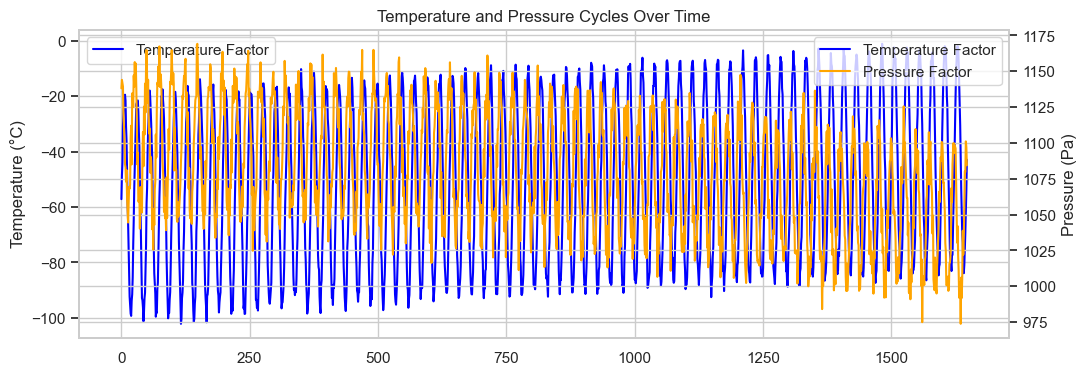

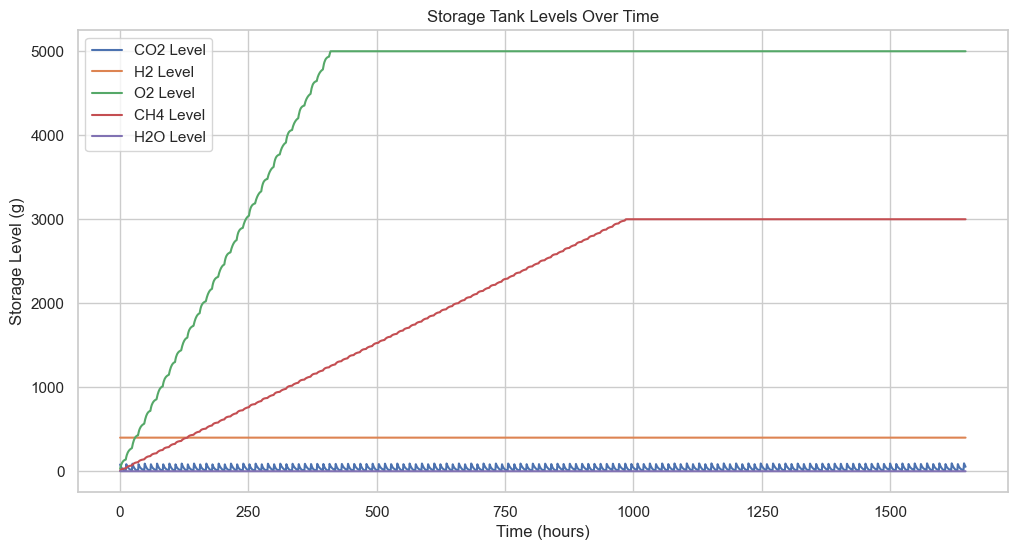

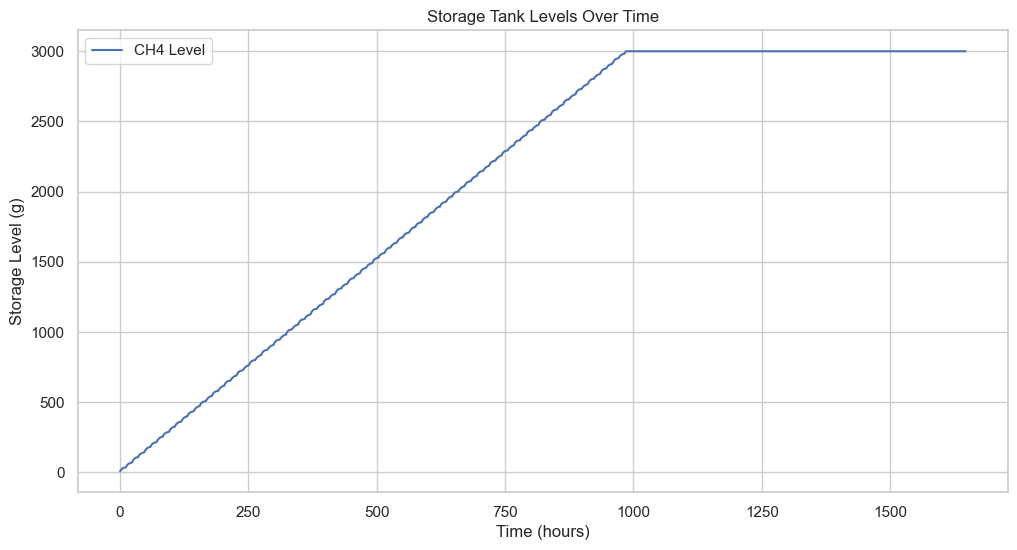

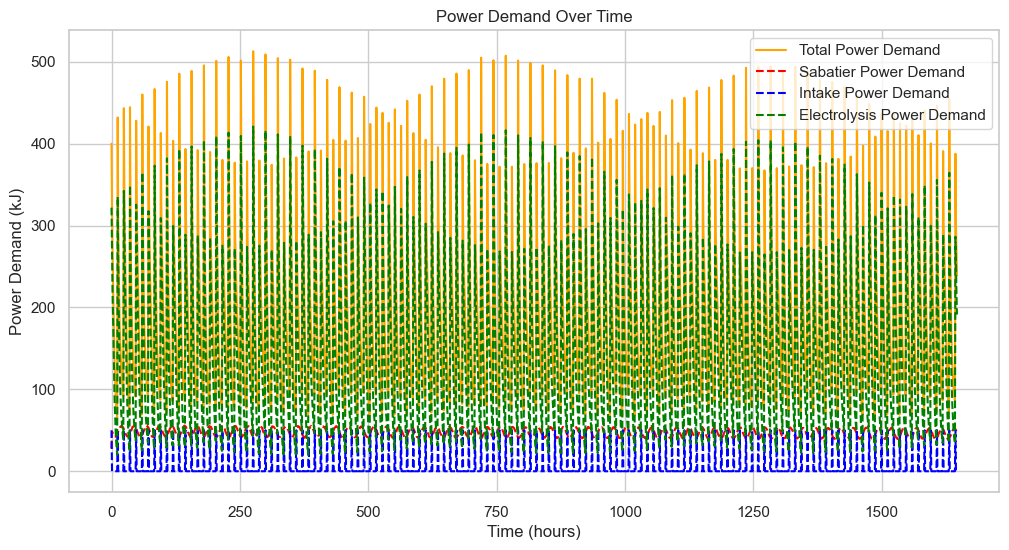

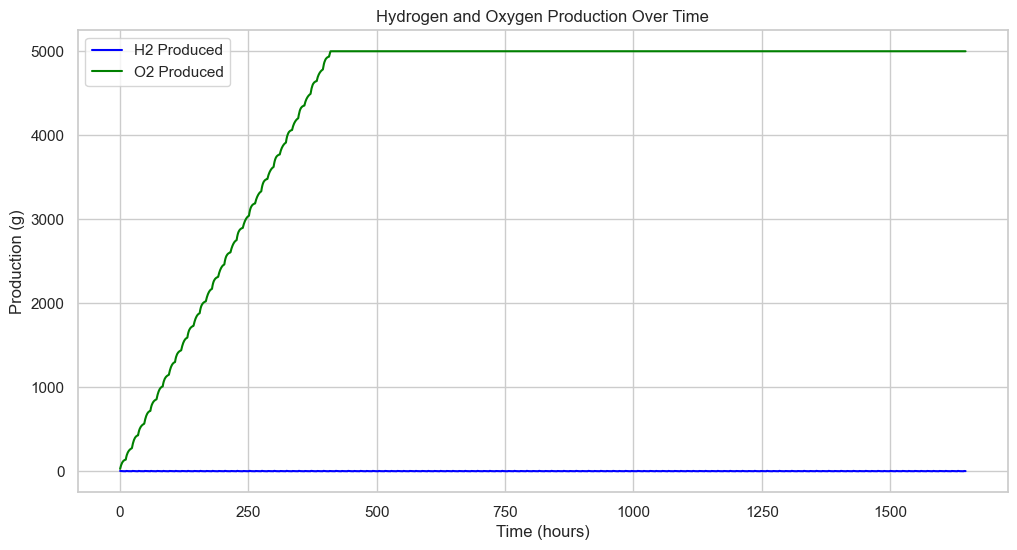

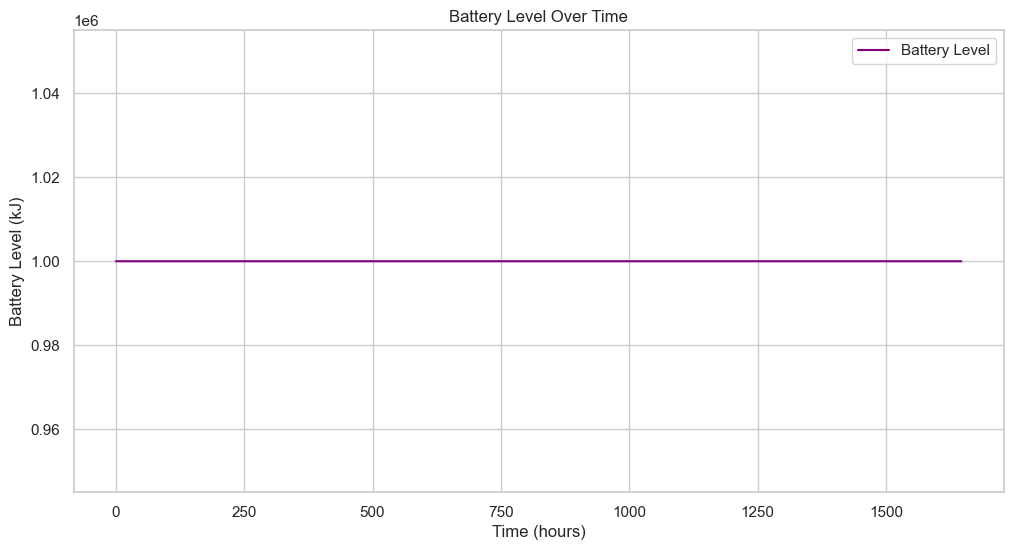

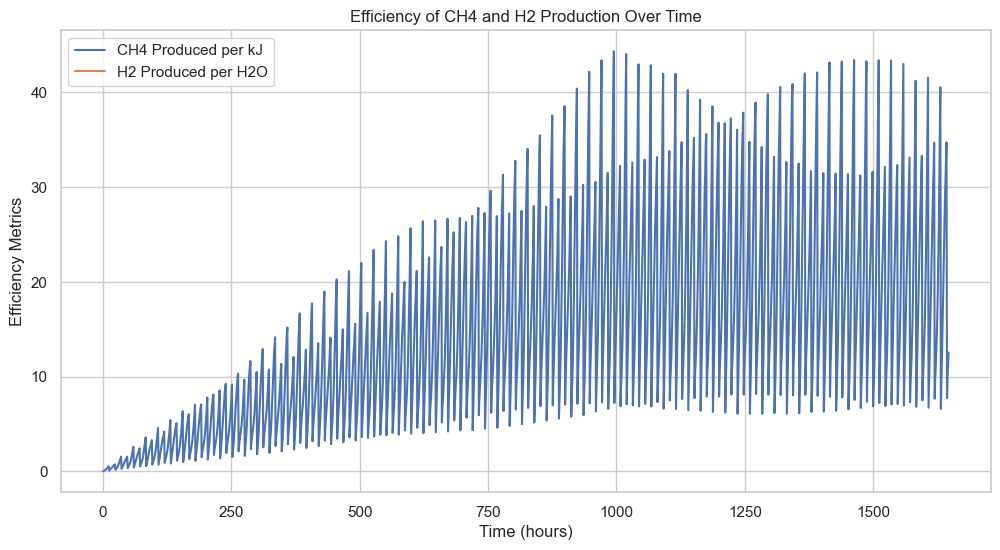

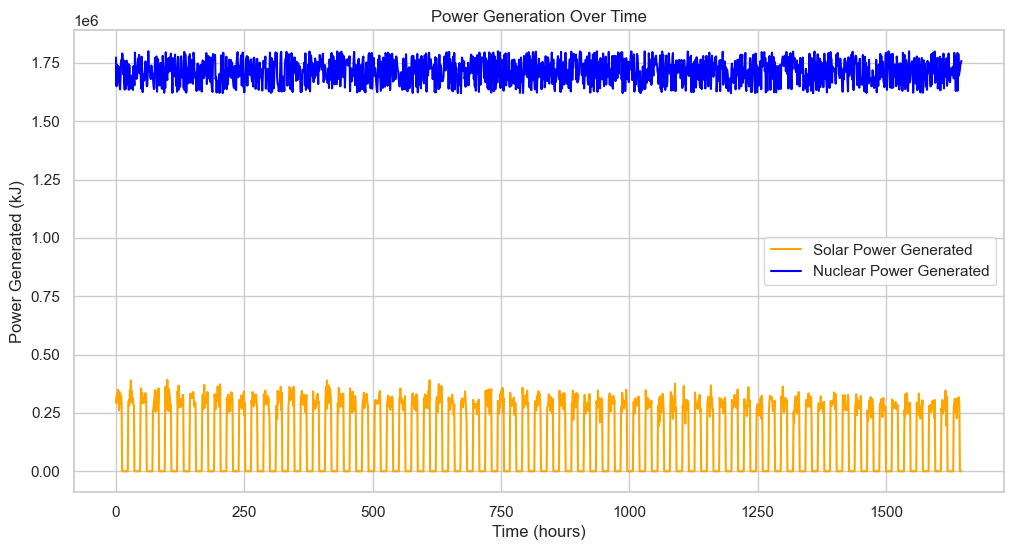

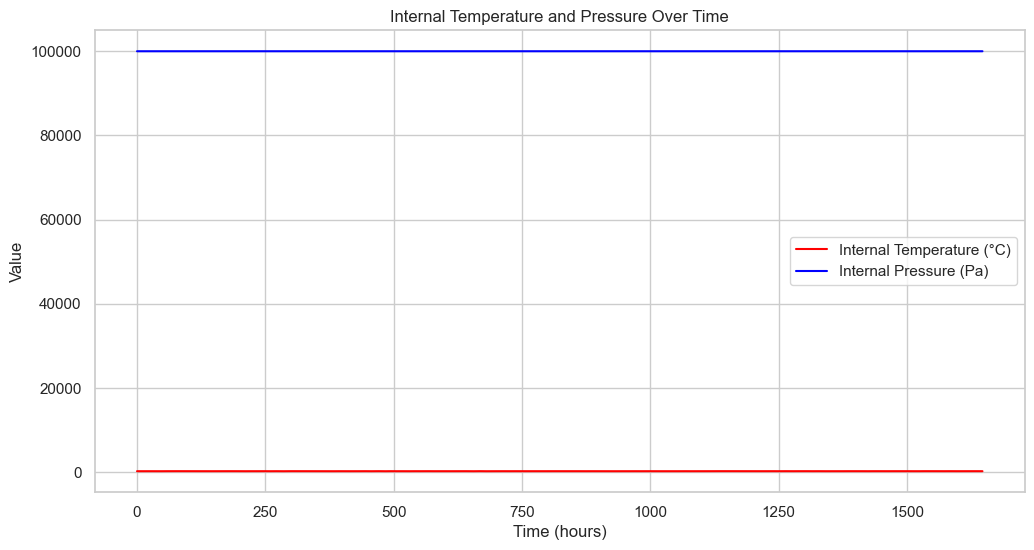

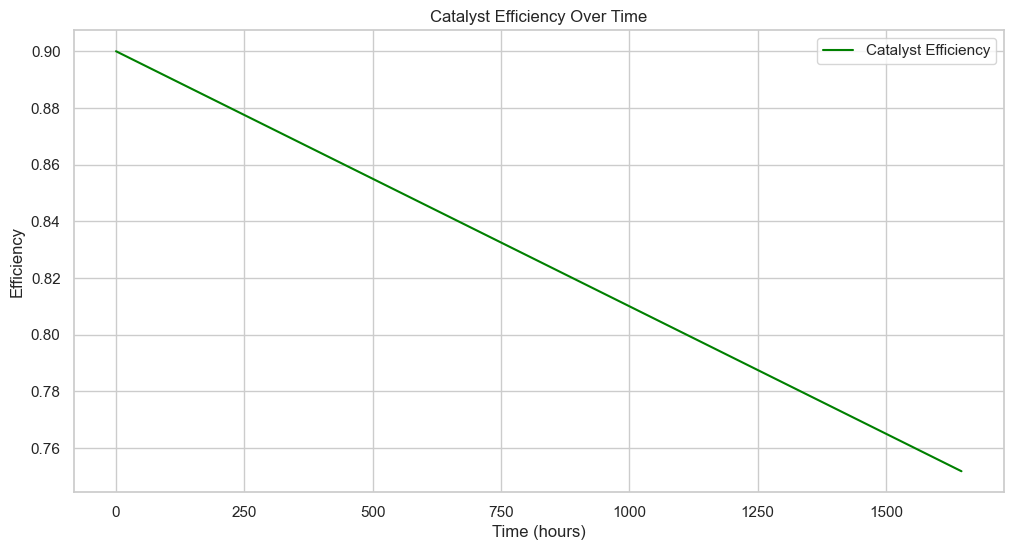

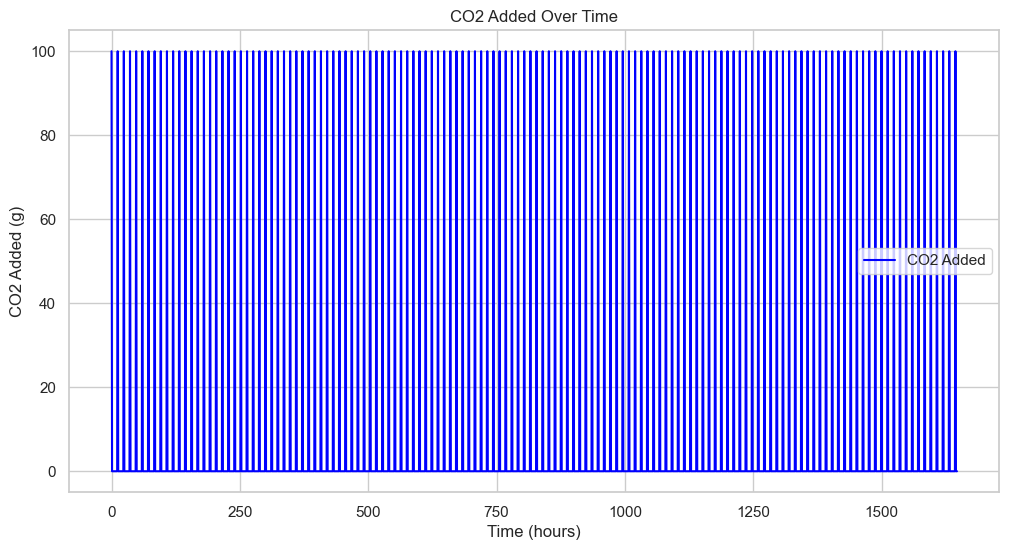

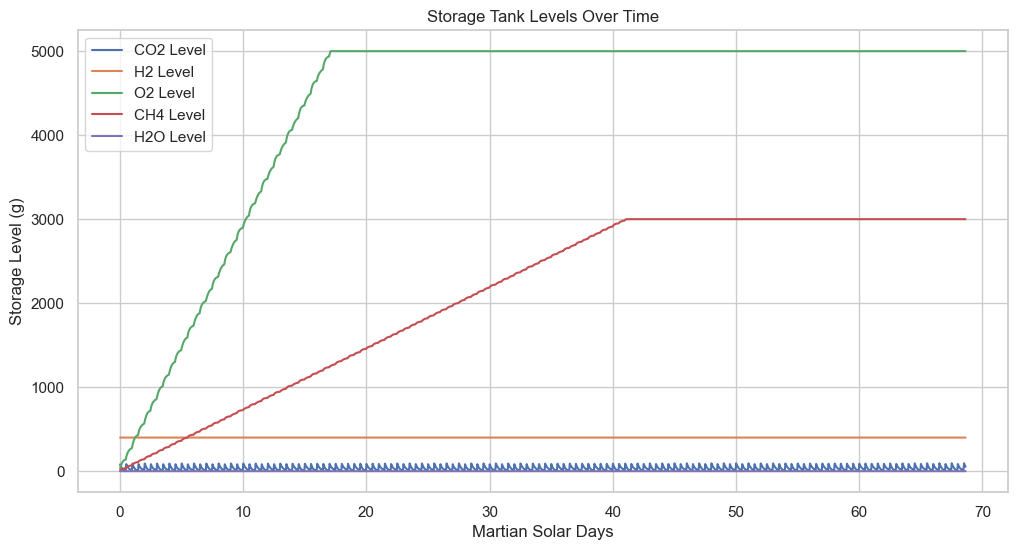

In [6]:
plt.figure(figsize=(12, 4))
ax = plt.gca()
sns.lineplot(temperature_cycle_c, label='Temperature Factor', ax = ax, color='blue')
ax.set_ylabel("Temperature (°C)")
ax2 = plt.twinx()
sns.lineplot(pressure_cycle_pa, label='Pressure Factor', ax = ax2, color='orange')
ax2.set_ylabel("Pressure (Pa)")
plt.xlabel("Time (hours)")
plt.title("Temperature and Pressure Cycles Over Time")
# combine the legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["CO2_level"], label='CO2 Level')
plt.plot(simulation_df["H2_level"], label='H2 Level')
plt.plot(simulation_df["O2_level"], label='O2 Level')
plt.plot(simulation_df["CH4_level"], label='CH4 Level')
plt.plot(simulation_df["H2O_level"], label='H2O Level')
plt.xlabel("Time (hours)")
plt.ylabel("Storage Level (g)")
plt.title("Storage Tank Levels Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["CH4_level"], label='CH4 Level')
plt.xlabel("Time (hours)")
plt.ylabel("Storage Level (g)")
plt.title("Storage Tank Levels Over Time")
plt.legend()
plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(simulation_df["H2O_level"], label='H2O Level')
# plt.xlabel("Time (hours)")
# plt.ylabel("Storage Level (g)")
# plt.title("Storage Tank Levels Over Time")
# plt.legend()
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(simulation_df["CO2_level"], label='CO2 Level')
# plt.plot(simulation_df["H2_level"], label='H2 Level')
# plt.plot(simulation_df["O2_level"], label='O2 Level')
# plt.xlabel("Time (hours)")
# plt.ylabel("Storage Level (g)")
# plt.title("Storage Tank Levels Over Time")
# plt.legend()
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(simulation_df["CH4_level"], label='CH4 Level')
# plt.xlabel("Time (hours)")
# plt.ylabel("Storage Level (g)")
# plt.title("Storage Tank Levels Over Time")
# plt.legend()
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(simulation_df["H2O_level"], label='H2O Level')
# plt.xlabel("Time (hours)")
# plt.ylabel("Storage Level (g)")
# plt.title("Storage Tank Levels Over Time")
# plt.legend()
# plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["power_demand"], label='Total Power Demand', color='orange')
plt.plot(simulation_df["sabatier_power_demand"], label='Sabatier Power Demand', color='red', linestyle='dashed')
plt.plot(simulation_df["intake_power_demand"], label='Intake Power Demand', color='blue', linestyle='dashed')
plt.plot(simulation_df["electrolysis_power_demand"], label='Electrolysis Power Demand', color='green', linestyle='dashed')
plt.xlabel("Time (hours)")
plt.ylabel("Power Demand (kJ)")
plt.title("Power Demand Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["H2_produced"], label='H2 Produced', color='blue')
plt.plot(simulation_df["O2_produced"], label='O2 Produced', color='green')
plt.xlabel("Time (hours)")
plt.ylabel("Production (g)")
plt.title("Hydrogen and Oxygen Production Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["battery_level"], label='Battery Level', color='purple')
plt.xlabel("Time (hours)")
plt.ylabel("Battery Level (kJ)")
plt.title("Battery Level Over Time")
plt.legend()
plt.show()

simulation_df['CH4_per_kJ'] = simulation_df['CH4_level'] / simulation_df['power_demand']
simulation_df['H2_per_H2O'] = simulation_df['H2_produced'] / simulation_df['H2O_level']
plt.figure(figsize=(12, 6))
sns.lineplot(data=simulation_df, x=simulation_df.index, y="CH4_per_kJ", label="CH4 Produced per kJ")
sns.lineplot(data=simulation_df, x=simulation_df.index, y="H2_per_H2O", label="H2 Produced per H2O")
plt.xlabel("Time (hours)")
plt.ylabel("Efficiency Metrics")
plt.title("Efficiency of CH4 and H2 Production Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["solar_power_generated"], label='Solar Power Generated', color='orange')
plt.plot(simulation_df["nuclear_power_generated"], label='Nuclear Power Generated', color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Power Generated (kJ)")
plt.title("Power Generation Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["internal_temp_c"], label='Internal Temperature (°C)', color='red')
plt.plot(simulation_df["internal_pressure_pa"], label='Internal Pressure (Pa)', color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Value")
plt.title("Internal Temperature and Pressure Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["catalyst_efficiency"], label='Catalyst Efficiency', color='green')
plt.xlabel("Time (hours)")
plt.ylabel("Efficiency")
plt.title("Catalyst Efficiency Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["CO2_added"], label='CO2 Added', color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("CO2 Added (g)")
plt.title("CO2 Added Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(simulation_df["sol"], simulation_df["CO2_level"], label='CO2 Level')
plt.plot(simulation_df["sol"], simulation_df["H2_level"], label='H2 Level')
plt.plot(simulation_df["sol"], simulation_df["O2_level"], label='O2 Level')
plt.plot(simulation_df["sol"], simulation_df["CH4_level"], label='CH4 Level')
plt.plot(simulation_df["sol"], simulation_df["H2O_level"], label='H2O Level')
plt.xlabel("Martian Solar Days")
plt.ylabel("Storage Level (g)")
plt.title("Storage Tank Levels Over Time")
plt.legend()
plt.show()